# 環境
DockerのPython環境(Dockerで構築したPython環境だとete3のバグを治すのが面倒だったのでminicondaの方が良いかも)  
###########################  
NAME="Debian GNU/Linux"  
VERSION_ID="12"  
VERSION="12 (bookworm)"  
VERSION_CODENAME=bookworm  
###########################  

Python 3.10.11  
CHAIDの構築、可視化に必要なパッケージと使用したバージョン

- ete3 --'3.1.3'
- CHAID --'5.4.1'
- PyQt5 --'5.15.10'  ete3の内部で使う。
- sklearn2pmml --'0.105.2'  CHAIDのwrapper。sklearnライクに使える。
- svglib --'1.5.1'  svgファイルをpdfファイルやpngファイルに変換するのに使う。
- reportlab --'4.2.0'  svgファイルをpdfファイルやpngファイルに変換するのに使う。
- rlPyCairo --'0.3.0'  svgファイルをpdfファイルやpngファイルに変換するのに使う。
- pykakasi --'2.2.1'  必須ではない。日本語のカラムやカテゴリーを可視化できないのでこれでローマ字に変えたりすると良いかも。

# パッケージインポート

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import japanize_matplotlib

import os
import sys
import ast
import json
import glob
import tqdm as tq
from tqdm import tqdm
import scipy
import gc
import pickle
import datetime as dt
import collections
import time
from dateutil.relativedelta import relativedelta

import sklearn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import load_breast_cancer

import string
import re
from collections import OrderedDict
from collections import Counter
import itertools
os.environ['QT_QPA_PLATFORM']='offscreen'  # ete3をJupyterで使うときこれをしないとカーネルが落ちる
sns.set()

In [2]:
# 可視化用パッケージ
import ete3
from ete3 import Tree, TreeStyle, TextFace, PieChartFace, BarChartFace
import PyQt5
import sklearn2pmml
from sklearn2pmml.tree.chaid import CHAIDClassifier
import CHAID
from CHAID import Tree as chaidTree
import svglib
from svglib.svglib import svg2rlg
import reportlab
from reportlab.graphics import renderPDF, renderPM
import rlPyCairo
import pykakasi  # 日本語の可視化ができないのでこれでローマ字に変えたりしましょう

from six import StringIO  # sklearnのCART可視化用
import pydotplus  # sklearnのCART可視化用
from IPython.display import Image  # sklearnのCART可視化用
import dtreeviz  # sklearnのCART可視化用

In [3]:
# # 日本語フォント読み込み
# jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
# jpn_font=jpn_fonts[0]
jpn_font = japanize_matplotlib.get_font_ttf_path()
prop = fm.FontProperties(fname=jpn_font)
print(jpn_font)
# plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定

/usr/local/lib/python3.10/site-packages/japanize_matplotlib/fonts/ipaexg.ttf


# DATA  
sklearnの乳癌診断のデータ

In [4]:
# Load Data
breast_cancer = load_breast_cancer()
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df['target'] = breast_cancer.target
colx = breast_cancer.feature_names
coly = 'target'

# CART  
CARTアルゴリズムの可視化

## 説明変数がすべて連続値の場合

In [5]:
# 学習
df_add = df.copy()
clf = DecisionTreeClassifier(min_samples_split=100, max_depth=4, random_state=0)
clf.fit(df_add[colx].to_numpy(), df_add[coly].to_numpy())

DecisionTreeClassifier(max_depth=4, min_samples_split=100, random_state=0)

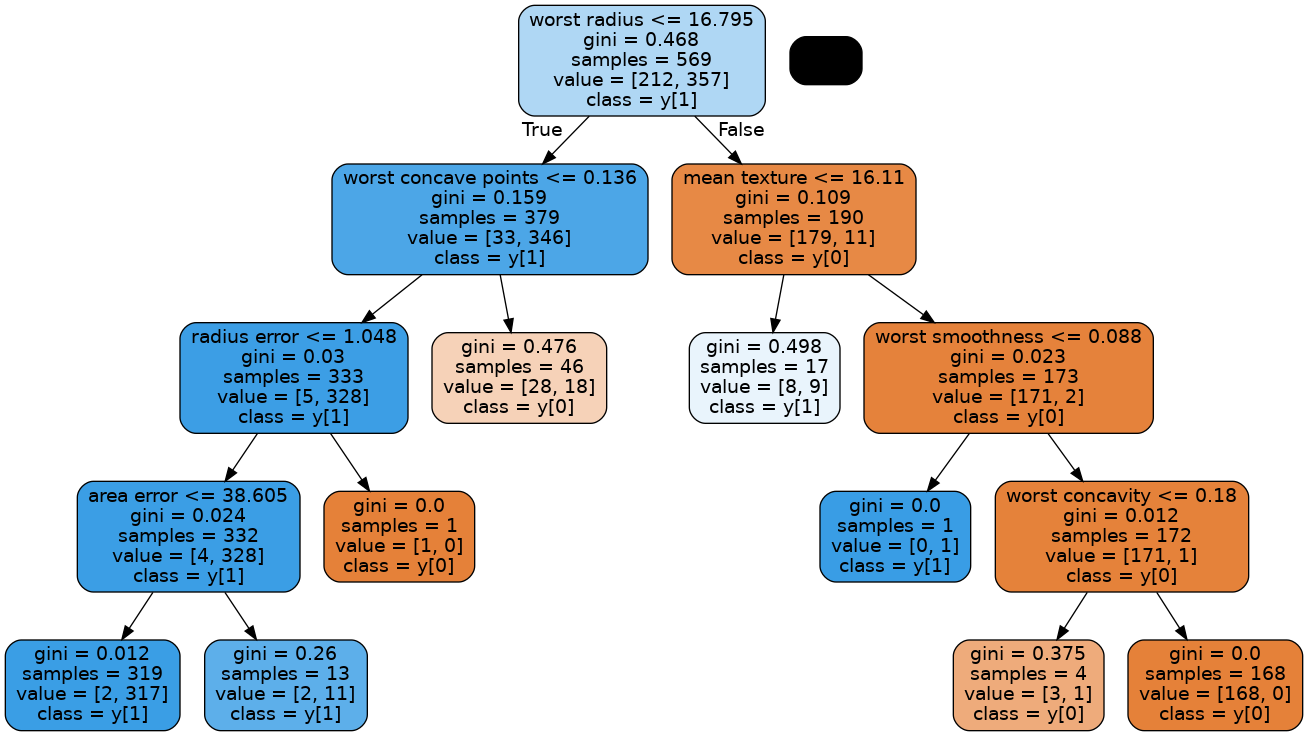

In [6]:
# 決定木の可視化 sklearn標準
dot_data = StringIO()
sklearn.tree.export_graphviz(clf, out_file=dot_data
                             , feature_names=colx
                             , class_names=True
                             , filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

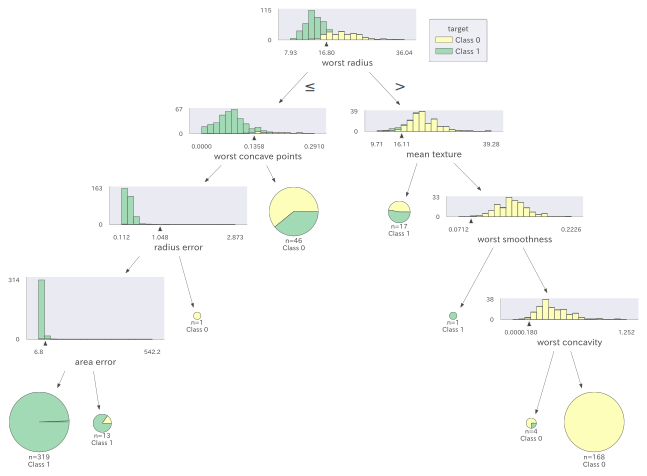

In [7]:
# dtreevizでも可視化
viz = dtreeviz.model(clf#,tree_index=1
                     , X_train=df_add[colx],y_train=df_add[coly]
                     , feature_names=colx
                     , target_name=coly)
viz.view(fontname=prop.get_name())

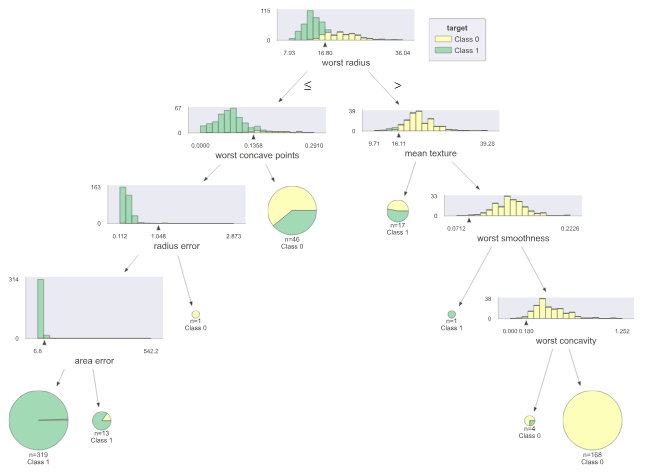

In [8]:
# ete3によるCARTアルゴリズムの可視化関数
def makeTreeEte3CART(clffit, tree_cols, obj_unique, le_list_rename=None, dtype_arr=None, fsize=100, height=300, width=300, diameter=100, rotation=0, name='tmp'):
    # eteのTreeインスタンスを構築
    tree = Tree()
    
    # node size
    # 各ノードのサンプル数の順に木のノードの大きさを変える
    # tree_.n_node_samplesはノードごとのサンプル数を返す
    nodesize={}
    for i, n in enumerate(np.sort(clffit.tree_.n_node_samples)):
        nodesize[n] = i+1
        
    # 各ノードを設定していく
    # tree_.node_countはノード数を返す
    for i in range(clffit.tree_.node_count):
        #i=0、つまりルートノードの名称を0にする
        if i == 0:
            tree.name = str(0)
        
        # 設定するノードを指定
        # name=str(i)であるete3親ノードの設定をする
        node = tree.search_nodes(name=str(i))[0]
        
        # ノードごとに目的変数別の%を計算し、配分の円グラフを作成
        Graph_Object = PieChartFace(percents=clffit.tree_.value[i][0] / clffit.tree_.value[i].sum() * 100  # 目的変数別の割合
                                   , width=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                   , height=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
                                   , colors=ete3.COLOR_SCHEMES['set2'])  # グラフの色
        # ノードごとに目的変数別の数を計算し、barグラフを作成
        # Graph_Object = BarChartFace(values=clffit.tree_.value[i][0]  # 目的変数別のサンプル数
        #                             , width=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
        #                             , height=nodesize[clffit.tree_.n_node_samples[i]]*diameter  # nodesize辞書内の数値×diameter
        #                             , colors=ete3.COLOR_SCHEMES['set2'])  # グラフの色
        Graph_Object.opacity = 0.8
        #Graph_Object.hz_align = 2  # 0 left, 1 center, 2 right
        #Graph_Object.vt_align = 2  # 0 left, 1 center, 2 right
        
        #グラフをセット
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(Graph_Object, column=2, position="branch-right")

        # 左下の子ノードの設定をする
        if clffit.tree_.children_left[i] > -1:  # 左下に子ノードがある場合(-1の時、子ノードはない)
            # ノード名称はsklearnのtreeのリストIDと一致させる
            node.add_child(name=str(clffit.tree_.children_left[i]))  # ete3子ノード追加
            # 対象を子ノードに移す
            node = tree.search_nodes(name=str(clffit.tree_.children_left[i]))[0]
            # 分岐条件を追加
            # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
            if le_list_rename and dtype_arr:
                if dtype_arr[tree_cols[clffit.tree_.feature[i]]]=='object':
                    object_col = tree_cols[clffit.tree_.feature[i]]
                    node.add_face(TextFace(object_col, fsize=fsize)  # 特徴量の名前
                                  , column=0, position="branch-top")  # Text位置
                    category_number = int(np.floor(clffit.tree_.threshold[i]))
                    node.add_face(TextFace(le_list_rename[object_col][category_number], fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                else:
                    node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                    node.add_face(TextFace(u"<=" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置                
            else:
                node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                node.add_face(TextFace(u"<=" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                              , column=1, position="branch-bottom")  # Text位置
            # 親ノードに対象を戻しておく
            node = tree.search_nodes(name=str(i))[0]
        
        # 右下の子ノードの設定をする
        if clffit.tree_.children_right[i] > -1:  # 右下に子ノードがある場合(-1の時、子ノードはない)
            # ノード名称はsklearnのtreeのリストIDと一致させる
            node.add_child(name=str(clffit.tree_.children_right[i]))  # ete3子ノード追加
            # 対象を子ノードに移す
            node = tree.search_nodes(name=str(clffit.tree_.children_right[i]))[0]
            # 分岐条件を追加
            # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
            if le_list_rename and dtype_arr:
                if dtype_arr[tree_cols[clffit.tree_.feature[i]]]=='object':
                    object_col = tree_cols[clffit.tree_.feature[i]]
                    node.add_face(TextFace(object_col, fsize=fsize)  # 特徴量の名前
                                  , column=0, position="branch-top")  # Text位置
                    category_number = int(np.ceil(clffit.tree_.threshold[i]))
                    node.add_face(TextFace(le_list_rename[object_col][category_number], fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                else:
                    node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                    node.add_face(TextFace(">" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
            else:
                node.add_face(TextFace(tree_cols[clffit.tree_.feature[i]], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                node.add_face(TextFace(">" + "{0:.2f}".format(clffit.tree_.threshold[i]), fsize=fsize)  # 特徴量の分岐の閾値
                              , column=1, position="branch-bottom")  # Text位置
            # 親ノードに対象を戻しておく
            node = tree.search_nodes(name=str(i))[0]

        # ノード内のサンプル数や割合をテキストとして記す
        text1 = str(obj_unique[0])+":{0:.0f}".format(clffit.tree_.value[i][0][0] / clffit.tree_.n_node_samples[i] * 100) + "%"
        text1_1 = "{0:.0f}".format(clffit.tree_.n_node_samples[i])
        texts_ary = []
        for obj_i in obj_unique:# 各クラスのサンプル数
            txt = "{:.0f}:{:.0f}".format(obj_i, clffit.tree_.value[i][0][obj_i])
            texts_ary.append(txt)
        
        # 情報を書き込み
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(TextFace(text1_1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        node.add_face(TextFace(text1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        for txt_i in texts_ary:
            node.add_face(TextFace(txt_i, fsize=fsize)
                          , column=4, position="branch-right")

    # 図の回転
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.rotation = rotation
    # 図の保存
    tree.render(name+'.svg', h=height, w=width, tree_style=ts, dpi=250)
    try:
        from svglib.svglib import svg2rlg
        from reportlab.graphics import renderPDF, renderPM
        import rlPyCairo
        import sys
        filename = name+'.svg'
        drawing = svg2rlg(filename)
        renderPDF.drawToFile(drawing, filename + ".pdf")
        drawing = svg2rlg(filename)
        renderPM.drawToFile(drawing, filename + ".png", fmt="PNG", dpi=250)
    except ModuleNotFoundError:
        pass
    return tree

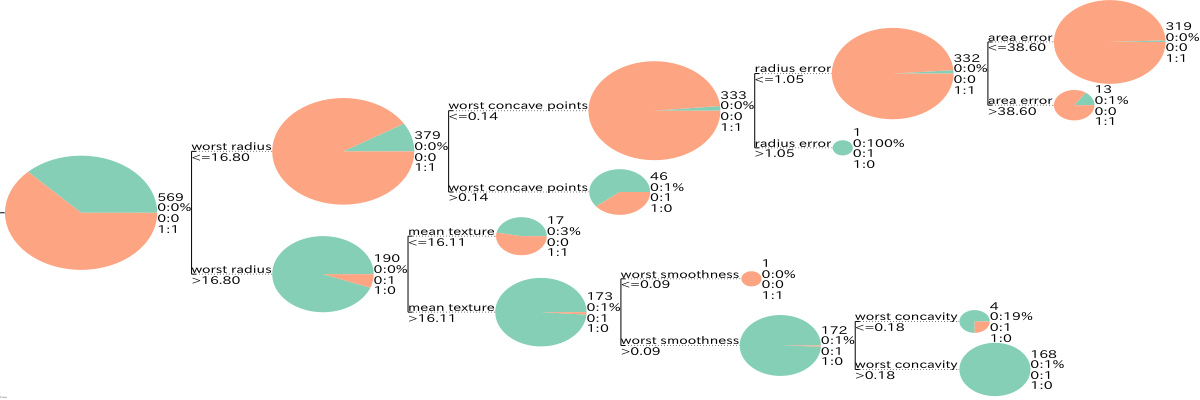

In [10]:
# 説明変数がすべて連続値の場合
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CART(clf, colx, obj_unique
                        , le_list_rename=None
                        , dtype_arr=None
                        , fsize=100, height=400, width=1200, rotation=0
                        , name='sklearn_CART')  # sklearn_CART.svgが保存される

# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 0
tree.render("%%inline", tree_style=ts, h=400, w=1200)

可視化した図① rotation=0   
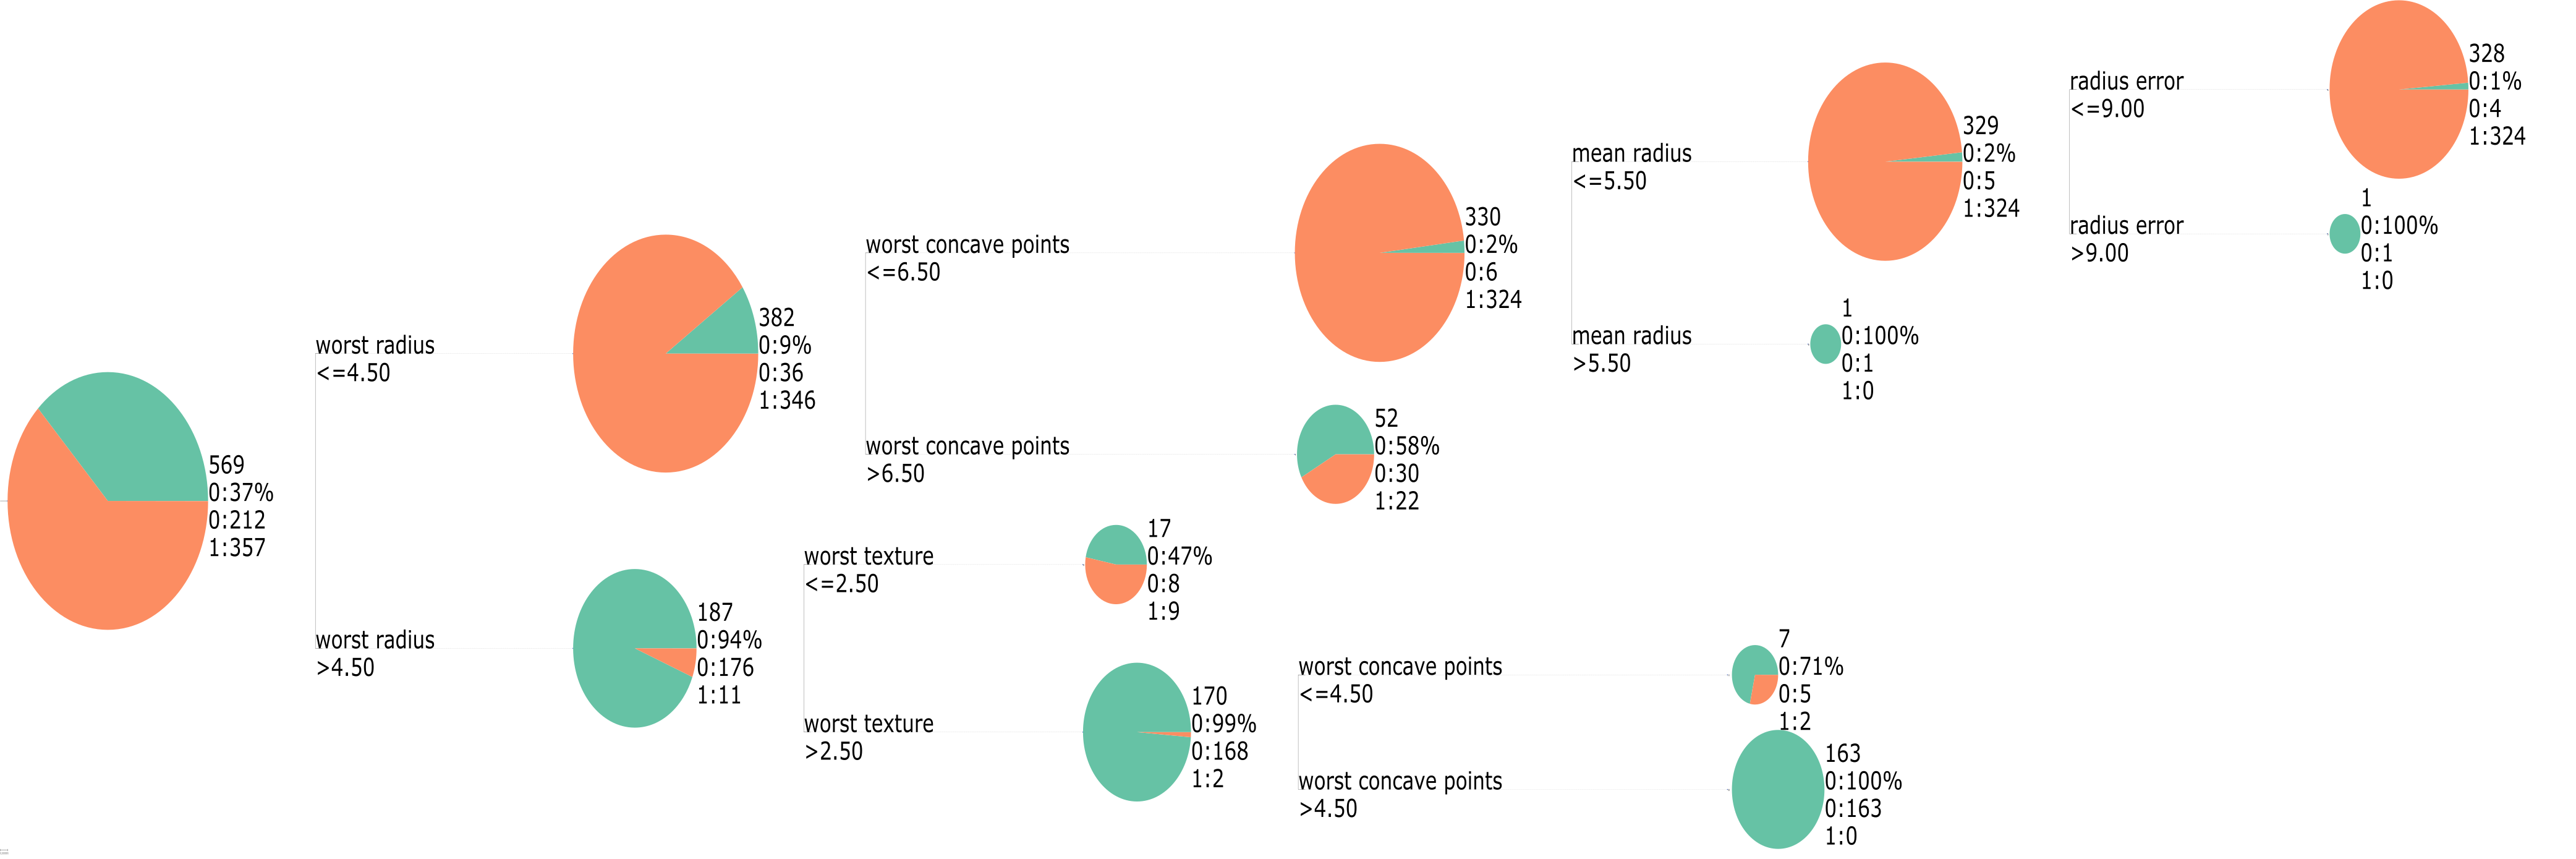

## 説明変数が一部質的データの場合

In [11]:
# 質的データがある時のCART可視化
# 今回は一部のデータが質的データと仮定
df_add = df.copy()
# ビニングにより順序尺度データに変換
bin_dict = {}  # 各カラムのビニング後の値とビニング前の数値の幅を辞書化する
dtype_arr = {}  # 各カラムのデータ型指定（'object'=質的データ。その他=連続値。）
category_cols = colx[:25]  # 今回は5つのカラムが質的データと仮定
continuous_cols = colx[25:]  # 残りのカラムが量的データと仮定
for i, col in enumerate(np.concatenate([category_cols,continuous_cols])):
    if col in category_cols:
        dtype_arr[col] = 'object'
        # 1次元クラスタリングで順序尺度化
        est = KBinsDiscretizer(n_bins=15, strategy="kmeans", encode='ordinal')
        bins_ = est.fit_transform(df_add[col].to_numpy().reshape(-1, 1))
        df_add[col] = bins_
        binmast = pd.DataFrame({'org':df[col].to_numpy(), 'bins':bins_.reshape(-1)})
        binmast_min = binmast.groupby('bins')['org'].min().reset_index()
        binmast_max = binmast.groupby('bins')['org'].max().reset_index()
        binmast = pd.merge(binmast_min, binmast_max, on=['bins'], how='outer', suffixes=['_min','_max'])
        binmast['ranges'] = binmast['org_min'].round(2).astype(str)+'-->'+binmast['org_max'].round(2).astype(str)  # ビン化する前の数値の範囲（例：'11.61-->12.7'）
        bin_dict_val = {row['bins']:row['ranges'] for index, row in binmast.iterrows()}
        bin_dict[col] = bin_dict_val
    else:
        dtype_arr[col] = 'number'
        bin_dict[col] = ''
print(dtype_arr)
print(bin_dict)
display(df_add.head())

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

{'mean radius': 'object', 'mean texture': 'object', 'mean perimeter': 'object', 'mean area': 'object', 'mean smoothness': 'object', 'mean compactness': 'object', 'mean concavity': 'object', 'mean concave points': 'object', 'mean symmetry': 'object', 'mean fractal dimension': 'object', 'radius error': 'object', 'texture error': 'object', 'perimeter error': 'object', 'area error': 'object', 'smoothness error': 'object', 'compactness error': 'object', 'concavity error': 'object', 'concave points error': 'object', 'symmetry error': 'object', 'fractal dimension error': 'object', 'worst radius': 'object', 'worst texture': 'object', 'worst perimeter': 'object', 'worst area': 'object', 'worst smoothness': 'object', 'worst compactness': 'number', 'worst concavity': 'number', 'worst concave points': 'number', 'worst symmetry': 'number', 'worst fractal dimension': 'number'}
{'mean radius': {0.0: '6.98-->9.04', 1.0: '9.17-->10.44', 2.0: '10.48-->11.6', 3.0: '11.61-->12.7', 4.0: '12.72-->13.98', 5.

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,7.0,0.0,8.0,5.0,9.0,11.0,10.0,10.0,10.0,9.0,...,1.0,10.0,8.0,9.0,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,9.0,4.0,9.0,7.0,4.0,2.0,3.0,5.0,5.0,1.0,...,4.0,8.0,8.0,4.0,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,9.0,7.0,8.0,7.0,8.0,6.0,6.0,9.0,8.0,2.0,...,5.0,7.0,7.0,7.0,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,2.0,6.0,3.0,1.0,13.0,12.0,8.0,8.0,11.0,14.0,...,5.0,3.0,2.0,13.0,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,9.0,2.0,9.0,7.0,6.0,5.0,6.0,8.0,5.0,2.0,...,1.0,7.0,7.0,6.0,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
# 学習
clf = DecisionTreeClassifier(min_samples_split=100, max_depth=5, random_state=0)
clf.fit(df_add[colx].to_numpy(), df_add[coly].to_numpy())

DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=0)

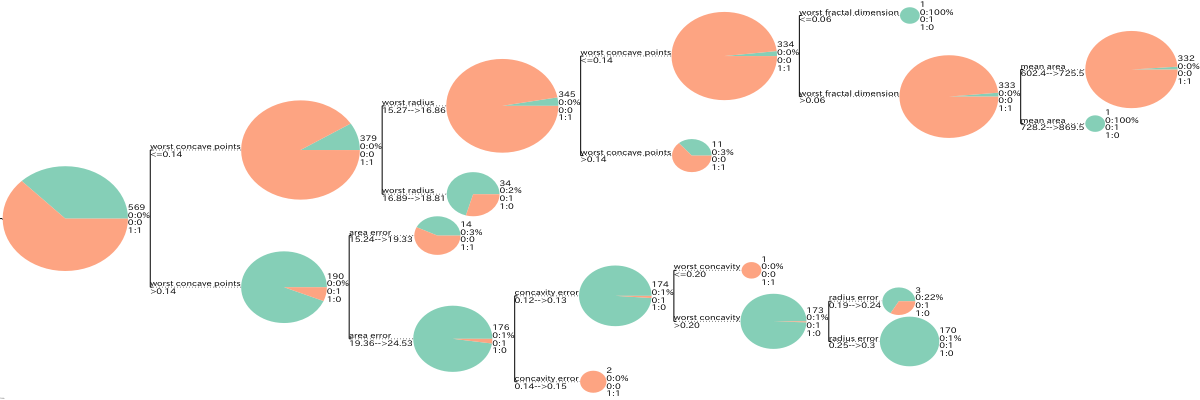

In [13]:
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CART(clf, colx, obj_unique
                        , le_list_rename=bin_dict
                        , dtype_arr=dtype_arr
                        , fsize=100, height=400, width=1200, rotation=0
                        , name='sklearn_CARTbin')  # sklearn_CARTbin.svgが保存される

# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 0
tree.render("%%inline", tree_style=ts, h=400, w=1200)

可視化した図② rotation=0   
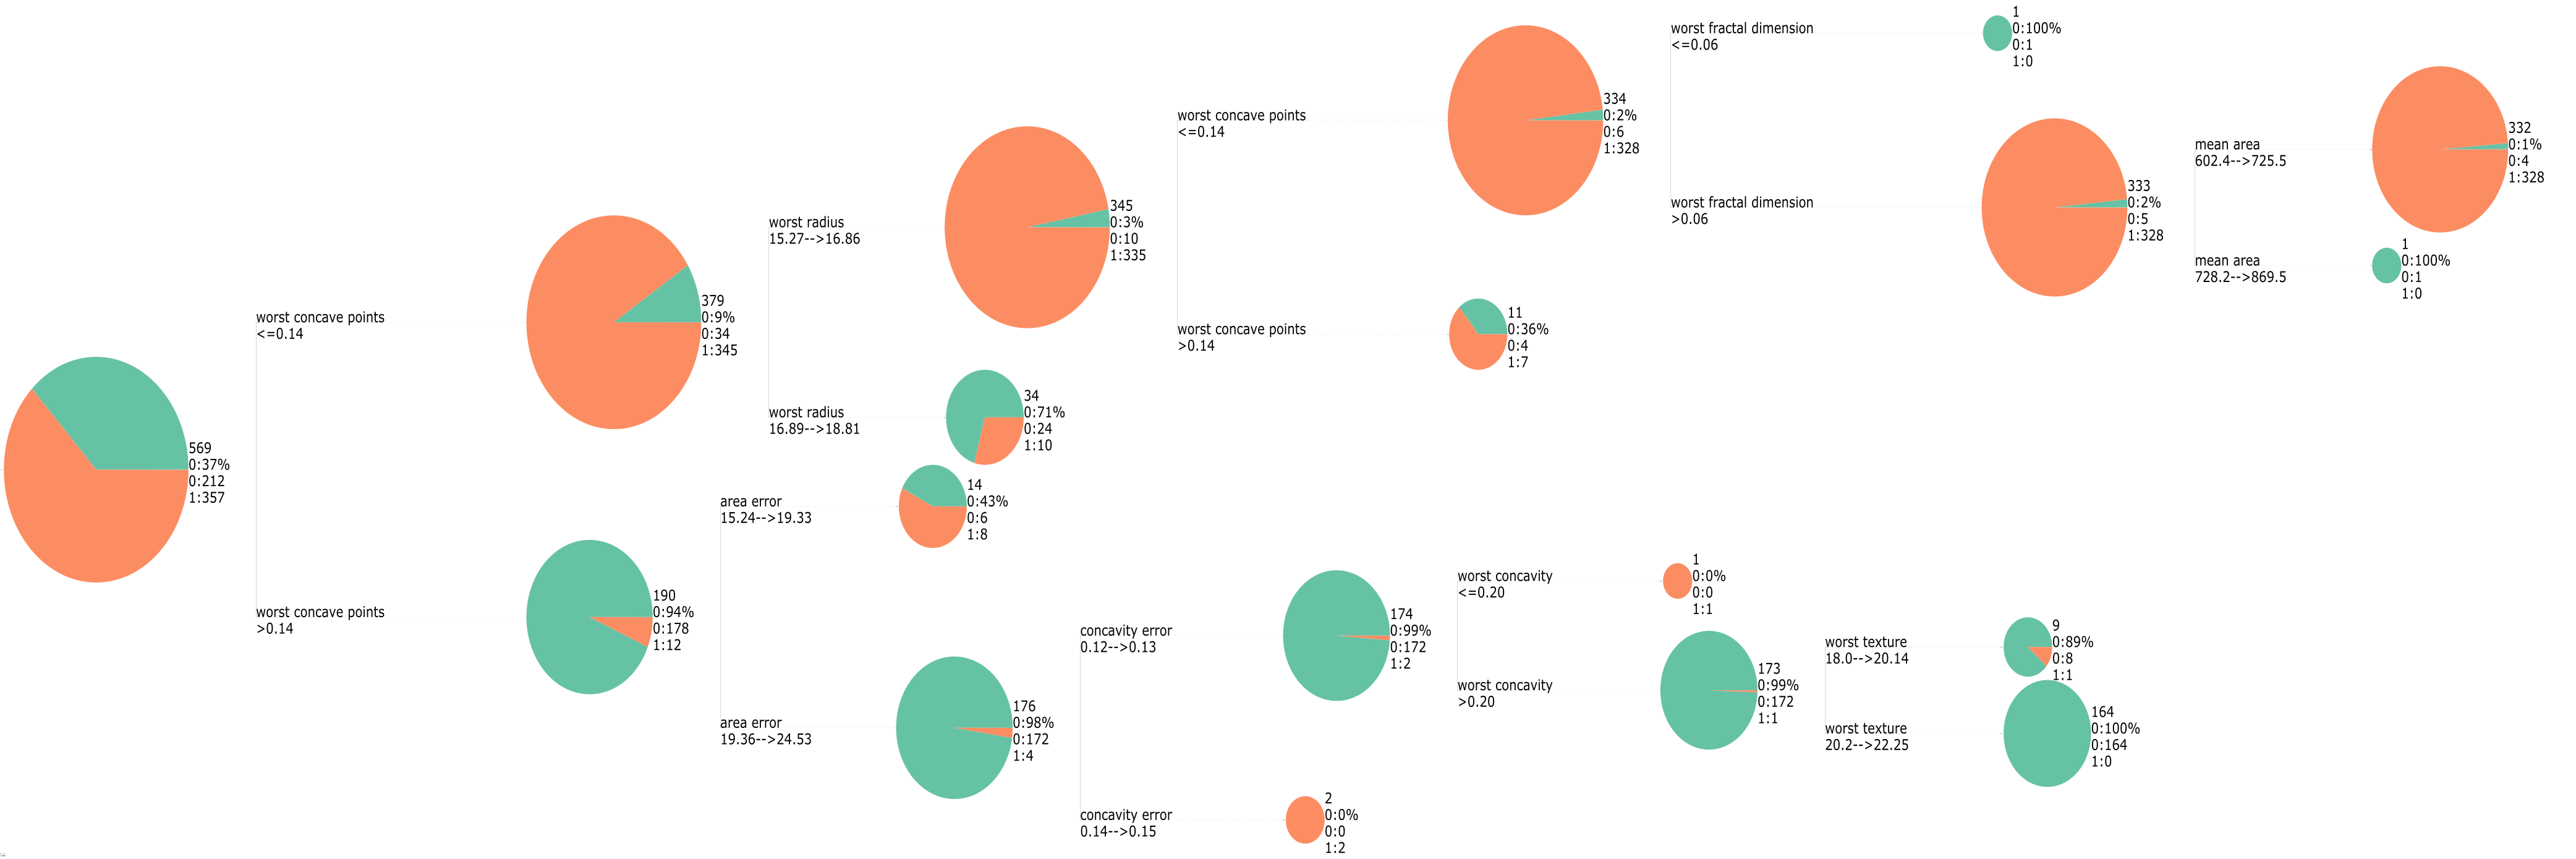

# CHAID

In [14]:
# CHAIDは説明変数が質的データのみ適用可
# すべてのデータを質的データ化する
df_add = df.copy()
# ビニングにより順序尺度データに変換
bin_dict = {}  # 各カラムのビニング後の値とビニング前の数値の幅を辞書化する
dtype_arr = {}  # 各カラムのデータ型指定（'object'=質的データ。その他=連続値。）
category_cols = colx  # すべてのデータを質的データへ
for i, col in enumerate(category_cols):
    dtype_arr[col] = 'object'
    # 1次元クラスタリングで順序尺度化
    est = KBinsDiscretizer(n_bins=15, strategy="kmeans", encode='ordinal')
    bins_ = est.fit_transform(df_add[col].to_numpy().reshape(-1, 1))
    df_add[col] = bins_
    binmast = pd.DataFrame({'org':df[col].to_numpy(), 'bins':bins_.reshape(-1)})
    binmast_min = binmast.groupby('bins')['org'].min().reset_index()
    binmast_max = binmast.groupby('bins')['org'].max().reset_index()
    binmast = pd.merge(binmast_min, binmast_max, on=['bins'], how='outer', suffixes=['_min','_max'])
    binmast['ranges'] = binmast['org_min'].round(2).astype(str)+'-->'+binmast['org_max'].round(2).astype(str)  # ビン化する前の数値の範囲（例：'11.61-->12.7'）
    bin_dict_val = {row['bins']:row['ranges'] for index, row in binmast.iterrows()}
    bin_dict[col] = bin_dict_val
print(dtype_arr)
print(bin_dict)
display(df_add.head())

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

{'mean radius': 'object', 'mean texture': 'object', 'mean perimeter': 'object', 'mean area': 'object', 'mean smoothness': 'object', 'mean compactness': 'object', 'mean concavity': 'object', 'mean concave points': 'object', 'mean symmetry': 'object', 'mean fractal dimension': 'object', 'radius error': 'object', 'texture error': 'object', 'perimeter error': 'object', 'area error': 'object', 'smoothness error': 'object', 'compactness error': 'object', 'concavity error': 'object', 'concave points error': 'object', 'symmetry error': 'object', 'fractal dimension error': 'object', 'worst radius': 'object', 'worst texture': 'object', 'worst perimeter': 'object', 'worst area': 'object', 'worst smoothness': 'object', 'worst compactness': 'object', 'worst concavity': 'object', 'worst concave points': 'object', 'worst symmetry': 'object', 'worst fractal dimension': 'object'}
{'mean radius': {0.0: '6.98-->9.04', 1.0: '9.17-->10.44', 2.0: '10.48-->11.6', 3.0: '11.61-->12.7', 4.0: '12.72-->13.98', 5.

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,7.0,0.0,8.0,5.0,9.0,11.0,10.0,10.0,10.0,9.0,...,1.0,10.0,8.0,9.0,9.0,8.0,13.0,9.0,8.0,0
1,9.0,4.0,9.0,7.0,4.0,2.0,3.0,5.0,5.0,1.0,...,4.0,8.0,8.0,4.0,2.0,3.0,9.0,4.0,5.0,0
2,9.0,7.0,8.0,7.0,8.0,6.0,6.0,9.0,8.0,2.0,...,5.0,7.0,7.0,7.0,5.0,5.0,12.0,7.0,5.0,0
3,2.0,6.0,3.0,1.0,13.0,12.0,8.0,8.0,11.0,14.0,...,5.0,3.0,2.0,13.0,12.0,8.0,13.0,14.0,13.0,0
4,9.0,2.0,9.0,7.0,6.0,5.0,6.0,8.0,5.0,2.0,...,1.0,7.0,7.0,6.0,2.0,4.0,8.0,2.0,3.0,0


In [15]:
def makeTreeEte3CHAID(tree_model, obj_unique, le_list_rename=None, fsize=100, height=300, width=300, diameter=100, rotation=90, name='tmp'):
    # CHAIDパッケージは必須
    try:
        import sklearn2pmml
        import CHAID
    except ModuleNotFoundError:
        import CHAID

    # CHAIDパッケージのオブジェクト
    if type(tree_model)==CHAID.Tree:
        print('CHAID Pakage Model', tree_model)
        tree_n_node_samples = [sum([v for v in tree_model.get_node(i).members.values()]) for i in range(tree_model.node_count)]
        tree_node_count = tree_model.node_count
        tree_value = [np.array([v for v in tree_model.get_node(i).members.values()]) for i in range(tree_model.node_count)]
        tree_value_sum = [sum([v for v in tree_model.get_node(i).members.values()]) for i in range(tree_model.node_count)]
        tree_node_id = [tree_model.get_node(i).node_id for i in range(tree_model.node_count)]
        tree_column = [tree_model.get_node(i).split.column for i in range(tree_model.node_count)]
        tree_groupings = [ast.literal_eval(tree_model.get_node(i).split.groupings) for i in range(tree_model.node_count)]
        tree_children = [tree_model.to_tree().children(i) for i in range(tree_model.node_count)]
    # CHAIDClassifierオブジェクト
    elif type(tree_model)==sklearn2pmml.tree.chaid.CHAIDClassifier:
        print('CHAIDClassifier Model for sklearn2pmml', tree_model)
        tree_n_node_samples = [sum([v for v in model.tree_.get_node(i).members.values()]) for i in range(model.tree_.node_count)]
        tree_node_count = model.tree_.node_count
        tree_value = [np.array([v for v in model.tree_.get_node(i).members.values()]) for i in range(model.tree_.node_count)]
        tree_value_sum = [sum([v for v in model.tree_.get_node(i).members.values()]) for i in range(model.tree_.node_count)]
        tree_node_id = [model.tree_.get_node(i).node_id for i in range(model.tree_.node_count)]
        tree_column = [model.tree_.get_node(i).split.column for i in range(model.tree_.node_count)]
        tree_groupings = [ast.literal_eval(model.tree_.get_node(i).split.groupings) for i in range(model.tree_.node_count)]
        tree_children = [model.tree_.to_tree().children(i) for i in range(model.tree_.node_count)]
    else:
        raise AttributeError('tree_model is incompatible')
            
    # eteのTreeインスタンスを構築
    tree = Tree()
    nodesize={}
    for i, n in enumerate(np.sort(tree_n_node_samples)):
        nodesize[n] = i+1
        
    # 各ノードを設定していく
    # tree_.node_countはノード数を返す
    for i in tqdm(range(tree_node_count)):
        if i == 0:
            tree.name = str(0)
        
        # 設定するノードを指定
        # name=str(i)であるete3親ノードの設定をする
        node = tree.search_nodes(name=str(i))[0]
        # ノードごとに目的変数別の%を計算し、配分の円グラフを作成
        Graph_Object = PieChartFace(percents=tree_value[i]/tree_value_sum[i] * 100  # 目的変数別の割合
                                   , width=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                   , height=nodesize[tree_n_node_samples[i]]*diameter  # nodesize辞書内の数値×100
                                   , colors=ete3.COLOR_SCHEMES['set2'])# グラフの色
        Graph_Object.opacity = 0.8
        node.add_face(Graph_Object, column=2, position="branch-right")
        if len(tree_children[i]) > 0:
            for chi in range(len(tree_children[i])):
                # 子ノードid
                child_id = tree_children[i][chi].identifier
                node.add_child(name=str(child_id))  # ete3子ノード追加
                # 対象を子ノードに移す
                node = tree.search_nodes(name=str(child_id))[0]
                # 分岐条件を追加
                # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
                node.add_face(TextFace(tree_column[i], fsize=fsize)  # 特徴量の名前
                              , column=0, position="branch-top")  # Text位置
                if le_list_rename:
                    replace_val = le_list_rename[tree_column[i]]
                    node.add_face(TextFace(str([replace_val[st] for st in tree_groupings[i][chi]]), fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                else:
                    node.add_face(TextFace(tree_groupings[i][chi], fsize=fsize)  # 特徴量の分岐の閾値
                                  , column=1, position="branch-bottom")  # Text位置
                # 親ノードに対象を戻しておく
                node = tree.search_nodes(name=str(i))[0]
        
        # ノード内のサンプル数や割合をテキストとして記す
        text1 = str(obj_unique[0])+":{0:.0f}".format(tree_value[i][0]/tree_value_sum[i] * 100) + "%"
        text1_1 = "{0:.0f}".format(tree_n_node_samples[i])
        texts_ary = []
        for obj_i in obj_unique:# 各クラスのサンプル数
            txt = "{:.0f}:{:.0f}".format(obj_i, tree_value[i][obj_i])
            texts_ary.append(txt)
        
        # 情報を書き込み
        # position='aligned', 'branch-top', 'float-behind', 'branch-bottom', 'float', 'branch-right'
        node.add_face(TextFace(text1_1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        node.add_face(TextFace(text1, fsize=fsize, fgcolor="black")
                      , column=4, position="branch-right")
        for txt_i in texts_ary:
            node.add_face(TextFace(txt_i, fsize=fsize)
                          , column=4, position="branch-right")

    # 図の回転
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.rotation = rotation
    # 図の保存
    tree.render(name+'.svg', h=height, w=width, tree_style=ts, dpi=250)
    try:
        from svglib.svglib import svg2rlg
        from reportlab.graphics import renderPDF, renderPM
        import rlPyCairo
        import sys
        filename = name+'.svg'
        drawing = svg2rlg(filename)
        renderPDF.drawToFile(drawing, filename + ".pdf")
        drawing = svg2rlg(filename)
        renderPM.drawToFile(drawing, filename + ".png", fmt="PNG", dpi=250)
    except ModuleNotFoundError:
        pass
    return tree

CHAID Pakage Model [([], {0: 212.0, 1: 357.0}, (worst perimeter, p=5.309716404879314e-93, score=435.7186085992034, groups=[[0.0, 1.0, 2.0], [3.0], [4.0], [5.0], [6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]]), dof=4)), ([0.0, 1.0, 2.0], {0: 2.0, 1: 223.0}, (worst concave points, p=7.10833548324026e-06, score=38.13489521369086, groups=[[0.0, 1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7.0], [8.0], [9.0]]), dof=8)), ([0.0, 1.0], {0: 0, 1: 54.0}, <Invalid Chaid Split> - the max depth has been reached), ([2.0], {0: 0, 1: 42.0}, <Invalid Chaid Split> - the max depth has been reached), ([3.0], {0: 1.0, 1: 48.0}, <Invalid Chaid Split> - the max depth has been reached), ([4.0], {0: 0, 1: 45.0}, <Invalid Chaid Split> - the max depth has been reached), ([5.0], {0: 0, 1: 21.0}, <Invalid Chaid Split> - the minimum parent node size threshold has been reached), ([6.0], {0: 0, 1: 8.0}, <Invalid Chaid Split> - the minimum parent node size threshold has been reached), ([7.0], {0: 1.0, 1: 2.0}, <Inva

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 9911.35it/s]


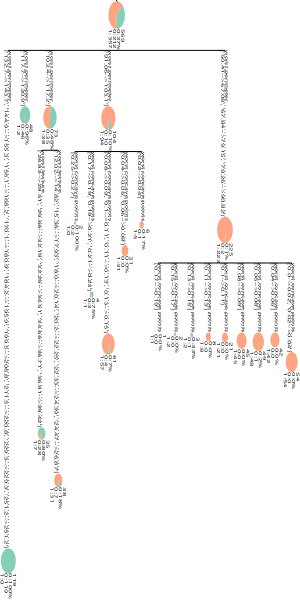

In [20]:
# CHAIDパッケージによりモデル構築
types_dic = dict(zip(colx, ['ordinal'] * len(colx)))  # すべての変数が順序尺度と指定
tree_model2 = chaidTree.from_pandas_df(df_add, types_dic, coly)  # モデル構築
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CHAID(tree_model2, obj_unique, le_list_rename=bin_dict
                         , fsize=400, height=300, width=600
                         , diameter=100, rotation=0
                         , name='CHAIDpackage_CHAID')  # CHAIDpackage_CHAID.svgが保存される
# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
tree.render("%%inline", tree_style=ts, h=600, w=300)

可視化した図③  rotation=0  
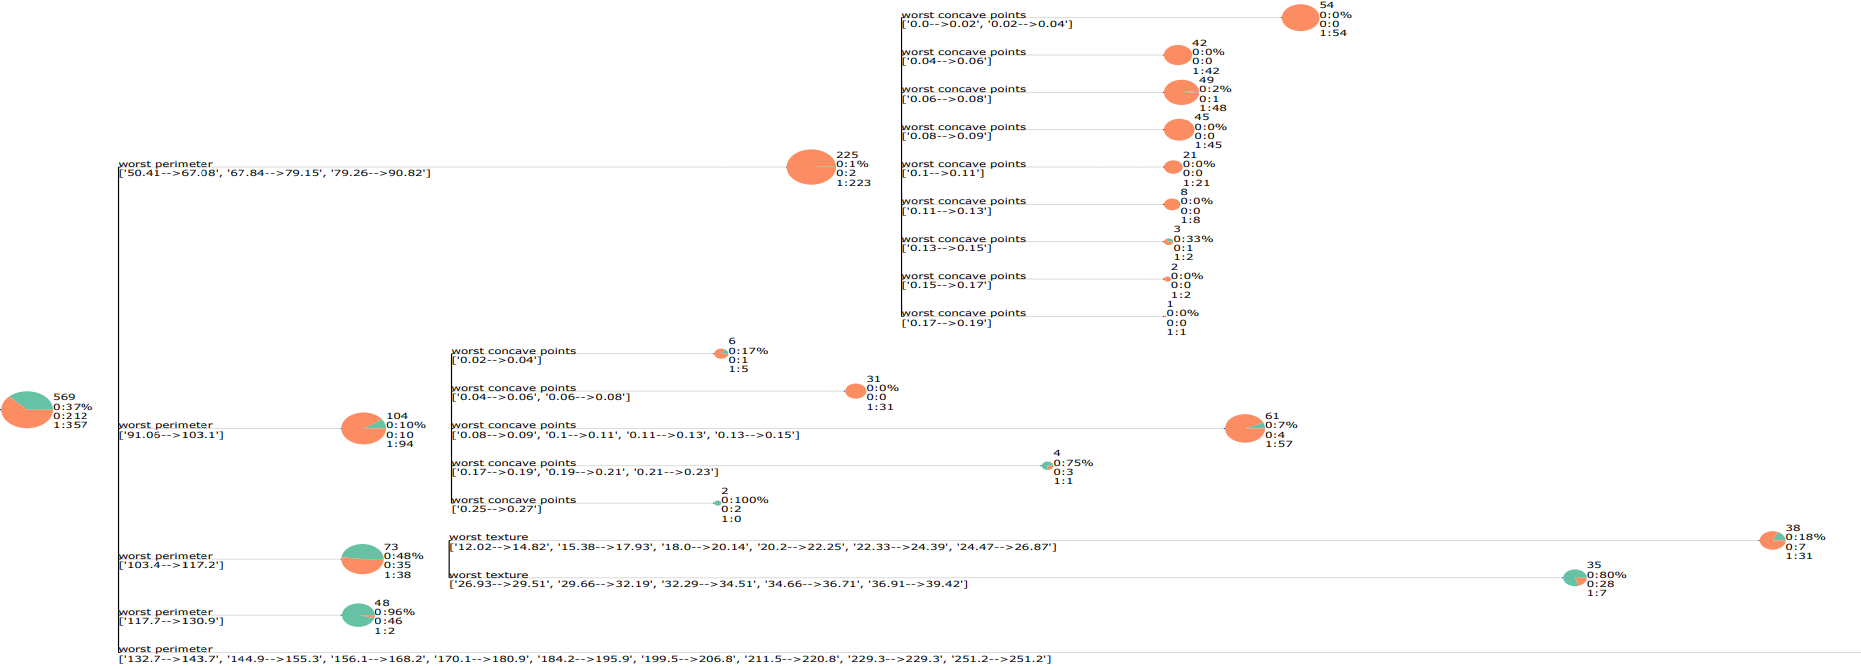

CHAIDClassifier Model for sklearn2pmml CHAIDClassifier(config={'max_depth': 5})


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 7186.50it/s]


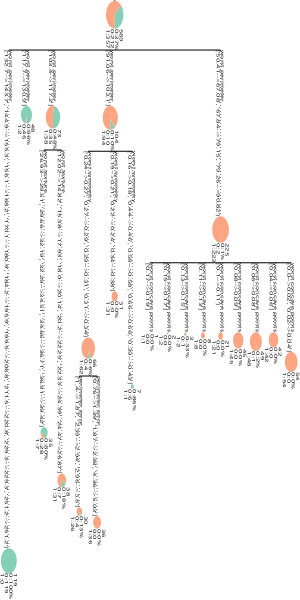

In [21]:
# sklearn2pmml パッケージのCHAIDClassifierによりモデル構築
# このCHAIDのwrapperでは順序尺度を選択できない（名義尺度のみ）
config = {"max_depth" : 5}
model = CHAIDClassifier(config = config)
model.fit(df_add[colx], df_add[coly])
obj_unique = np.sort(df_add[coly].unique())
tree = makeTreeEte3CHAID(model, obj_unique, le_list_rename=bin_dict
                         , fsize=400, height=300, width=600
                         , diameter=100, rotation=0
                         , name='CHAIDClassifier_CHAID')  # CHAIDClassifier_CHAID.svgが保存される
# Jupyter上に可視化(Jupyter上だとテキストが表示されない場合がある。保存したファイルにはテキストがあるはず。)
ts = TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
tree.render("%%inline", tree_style=ts, h=600, w=300)

可視化した図④  rotation=0  
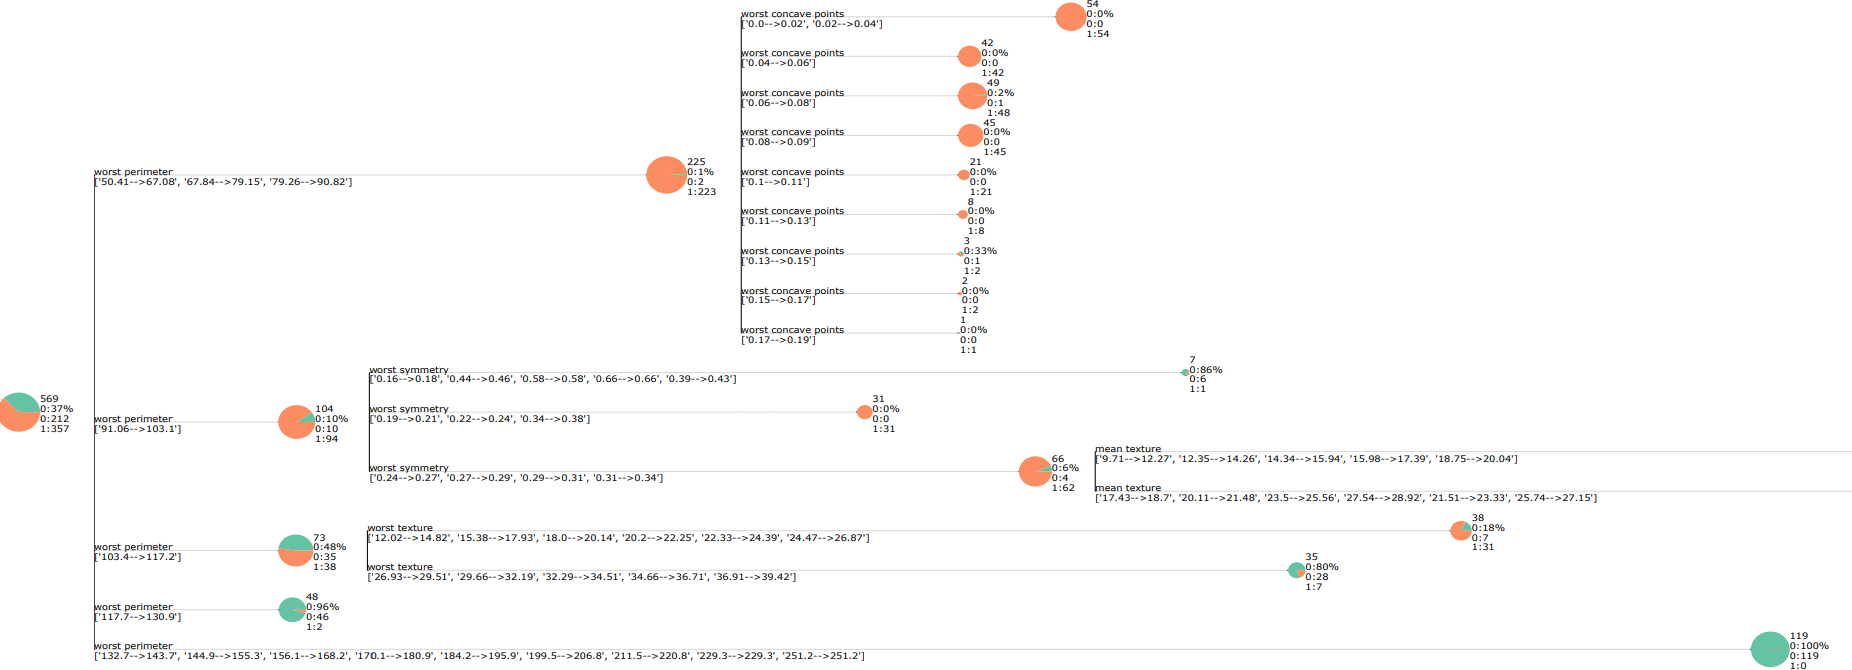

# RのCHAID

In [9]:
df_add = df.copy()
# CHAIDは説明変数が質的データのみ適用可
# すべてのデータを質的データ化する
df_add = df.copy()
# ビニングにより順序尺度データに変換
bin_dict = {}  # 各カラムのビニング後の値とビニング前の数値の幅を辞書化する
dtype_arr = {}  # 各カラムのデータ型指定（'object'=質的データ。その他=連続値。）
category_cols = colx  # すべてのデータを質的データへ
for i, col in enumerate(category_cols):
    dtype_arr[col] = 'object'
    # 1次元クラスタリングで順序尺度化
    est = KBinsDiscretizer(n_bins=15, strategy="kmeans", encode='ordinal')
    bins_ = est.fit_transform(df_add[col].to_numpy().reshape(-1, 1))
    df_add[col] = bins_
    binmast = pd.DataFrame({'org':df[col].to_numpy(), 'bins':bins_.reshape(-1)})
    binmast_min = binmast.groupby('bins')['org'].min().reset_index()
    binmast_max = binmast.groupby('bins')['org'].max().reset_index()
    binmast = pd.merge(binmast_min, binmast_max, on=['bins'], how='outer', suffixes=['_min','_max'])
    binmast['ranges'] = binmast['org_min'].round(2).astype(str)+'-->'+binmast['org_max'].round(2).astype(str)  # ビン化する前の数値の範囲（例：'11.61-->12.7'）
    bin_dict_val = {row['bins']:row['ranges'] for index, row in binmast.iterrows()}
    bin_dict[col] = bin_dict_val
print(dtype_arr)
print(bin_dict)
display(df_add.head())

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

{'mean radius': 'object', 'mean texture': 'object', 'mean perimeter': 'object', 'mean area': 'object', 'mean smoothness': 'object', 'mean compactness': 'object', 'mean concavity': 'object', 'mean concave points': 'object', 'mean symmetry': 'object', 'mean fractal dimension': 'object', 'radius error': 'object', 'texture error': 'object', 'perimeter error': 'object', 'area error': 'object', 'smoothness error': 'object', 'compactness error': 'object', 'concavity error': 'object', 'concave points error': 'object', 'symmetry error': 'object', 'fractal dimension error': 'object', 'worst radius': 'object', 'worst texture': 'object', 'worst perimeter': 'object', 'worst area': 'object', 'worst smoothness': 'object', 'worst compactness': 'object', 'worst concavity': 'object', 'worst concave points': 'object', 'worst symmetry': 'object', 'worst fractal dimension': 'object'}
{'mean radius': {0.0: '6.98-->9.04', 1.0: '9.17-->10.44', 2.0: '10.48-->11.6', 3.0: '11.61-->12.7', 4.0: '12.72-->13.98', 5.

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsampl

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,7.0,0.0,8.0,5.0,9.0,11.0,10.0,10.0,10.0,9.0,...,1.0,10.0,8.0,9.0,9.0,8.0,13.0,9.0,8.0,0
1,9.0,4.0,9.0,7.0,4.0,2.0,3.0,5.0,5.0,1.0,...,4.0,8.0,8.0,4.0,2.0,3.0,9.0,4.0,5.0,0
2,9.0,7.0,8.0,7.0,8.0,6.0,6.0,9.0,8.0,2.0,...,5.0,7.0,7.0,7.0,5.0,5.0,12.0,7.0,5.0,0
3,2.0,6.0,3.0,1.0,13.0,12.0,8.0,8.0,11.0,14.0,...,5.0,3.0,2.0,13.0,12.0,8.0,13.0,14.0,13.0,0
4,9.0,2.0,9.0,7.0,6.0,5.0,6.0,8.0,5.0,2.0,...,1.0,7.0,7.0,6.0,2.0,4.0,8.0,2.0,3.0,0


In [6]:
import rpy2
from rpy2 import robjects  # Rを起動
%load_ext rpy2.ipython

In [7]:
# %R install.packages('tidyverse')
# %R install.packages("CHAID", repos="http://R-Forge.R-project.org")
# %R install.packages('caret')
# %R install.packages('doParallel')

In [8]:
%%R
library('tidyverse')
library('CHAID')
library('caret')
library('doParallel')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


 要求されたパッケージ partykit をロード中です 
 要求されたパッケージ grid をロード中です 
 要求されたパッケージ libcoin をロード中です 
 要求されたパッケージ mvtnorm をロード中です 
 要求されたパッケージ lattice をロード中です 

 次のパッケージを付け加えます: ‘caret’ 

 以下のオブジェクトは ‘package:purrr’ からマスクされています:

    lift

 要求されたパッケージ foreach をロード中です 

 次のパッケージを付け加えます: ‘foreach’ 

 以下のオブジェクトは ‘package:purrr’ からマスクされています:

    accumulate, when

 要求されたパッケージ iterators をロード中です 
 要求されたパッケージ parallel をロード中です 


In [10]:
# Python側のデータを持ってくる
%R -i df_add
%R -i colx
%R -i coly
%R print(colx)
%R print(coly)

 [1] "mean radius"             "mean texture"           
 [3] "mean perimeter"          "mean area"              
 [5] "mean smoothness"         "mean compactness"       
 [7] "mean concavity"          "mean concave points"    
 [9] "mean symmetry"           "mean fractal dimension" 
[11] "radius error"            "texture error"          
[13] "perimeter error"         "area error"             
[15] "smoothness error"        "compactness error"      
[17] "concavity error"         "concave points error"   
[19] "symmetry error"          "fractal dimension error"
[21] "worst radius"            "worst texture"          
[23] "worst perimeter"         "worst area"             
[25] "worst smoothness"        "worst compactness"      
[27] "worst concavity"         "worst concave points"   
[29] "worst symmetry"          "worst fractal dimension"
[1] "target"


array(['target'], dtype='<U6')

In [25]:
%%R
# factor型に変更
df_add_f <- df_add %>% mutate(across(everything(), as.factor))
# NaNを除外
# df_add_f <- na.omit(df_add_f)
print(nrow(df_add_f))
print(ncol(df_add_f))
head(df_add_f)

[1] 569
[1] 31
  mean radius mean texture mean perimeter mean area mean smoothness
0           7            0              8         5               9
1           9            4              9         7               4
2           9            7              8         7               8
3           2            6              3         1              13
4           9            2              9         7               6
5           3            3              4         1              11
  mean compactness mean concavity mean concave points mean symmetry
0               11             10                  10            10
1                2              3                   5             5
2                6              6                   9             8
3               12              8                   8            11
4                5              6                   8             5
5                7              5                   6             8
  mean fractal dimension radius e

In [12]:
# 使用コア数
%R cl <- makePSOCKcluster(16)
%R registerDoParallel(cl)

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7efbe864c840> [RTYPES.CLOSXP]
R classes: ('function',)

In [36]:
%%R
# CHAIDモデルの構築
chaid_model <- chaid(target ~ .,
                     data = df_add_f,
                     control = chaid_control(alpha2=0.0001, alpha3=-1, alpha4=20, maxheight=5, minprob = 0.0001, minsplit = 1, minbucket = 1)
                    )#, minprob = 0.1, minsplit = 100, minbucket = 100, 


pdf( "mygraph.pdf", width = 20, height = 10 )
plot(chaid_model
     , gp = gpar(lty = "solid", lwd = 1, fontsize = 6, cex.node = 1., shape = "ellipse")
     , type = "simple"
     )
dev.off()

png 
  2 


RのChaid  
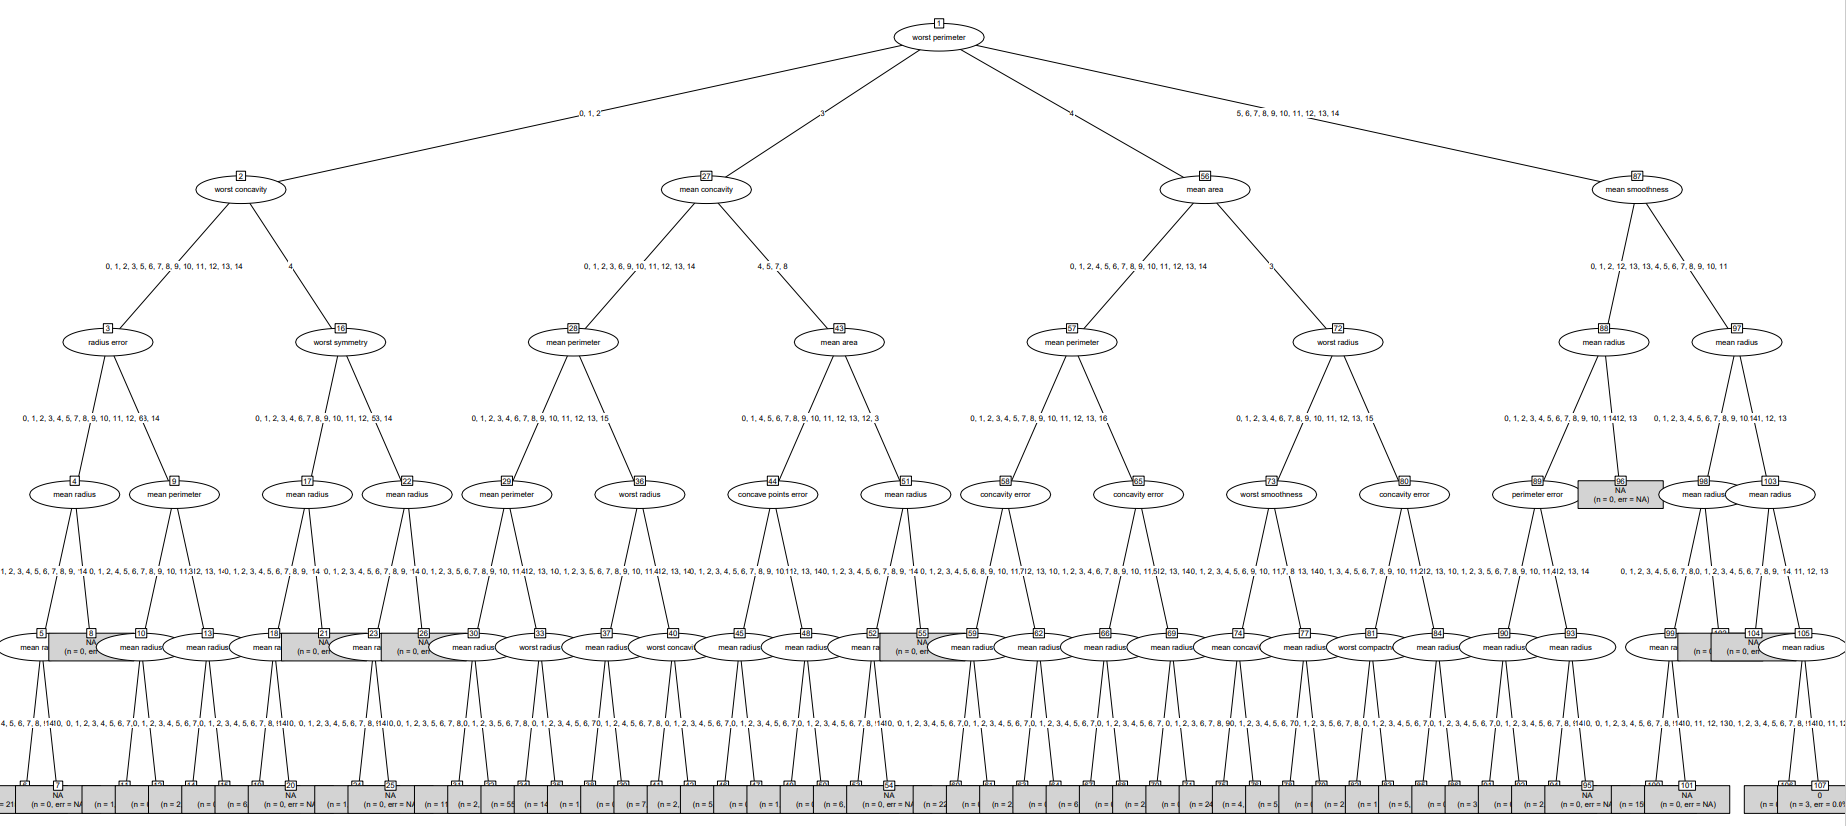